In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

foggie_dir = "/Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/"
# code_path should be the path to the directory where you've cloned the github repo.
code_path = "/Users/hylee/coding/foggie/foggie/"

# Finally, this is the name of the simulation output.
foggie_dir_output = "/Users/hylee/foggie/foggie_output/halo_008508/nref11c_nref9f/"
foggie_sim = "/Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/"
github_dir = "/Users/hylee/coding/foggie/foggie/" 
snap = "RD0042"
foggie_output = '/Users/hylee/foggie/foggie_output/halo_008508/nref11c_nref9f/'
track_dir = github_dir + 'halo_infos/008508/nref11c_nref9f/'
track_name = github_dir + 'halo_tracks/008508/nref11n_selfshield_15/halo_track_200kpc_nref9'
snap_name = foggie_sim + snap + '/' + snap

In [2]:
ds, refine_box = foggie_load(snap_name, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                             disk_relative=False, do_filter_particles=False, masses_dir=track_dir)

Opening snapshot /Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/RD0042/RD0042


yt : [INFO     ] 2023-06-28 11:18:46,584 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-06-28 11:18:46,585 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-06-28 11:18:46,585 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-28 11:18:46,587 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-06-28 11:18:46,588 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-06-28 11:18:46,588 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-06-28 11:18:46,589 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-06-28 11:18:46,589 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-06-28 11:18:46,590 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-06-28 11:18:46,591 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4251/4251 [00:00<00:00, 9290.11it/s]
yt : [INFO     ] 2023-06-28 11:18:47,244 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


In [3]:
size = 30 # size of one side of the FRB box [kpc]
width = (size, "kpc")  
xres = 70 #resolution in x axis [pixel]
yres = 70 #resolution in x axis [pixel]
axisx = "x"
axisy = "y"
axisz = "z"

res = [xres,yres] 

proj_x = ds.proj(("gas", "metallicity"), axisx , center = ds.halo_center_kpc, 
                data_source = refine_box, weight_field = "density")
proj_y = ds.proj(("gas", "metallicity"), axisy , center = ds.halo_center_kpc, 
              data_source = refine_box, weight_field = "density")
proj_z = ds.proj(("gas", "metallicity"), axisz , center = ds.halo_center_kpc, 
              data_source = refine_box, weight_field = "density")

#Setting fixed resolution buffer in 3 axes.

frb_x = proj_x.to_frb(width, res, center = ds.halo_center_kpc)
frb_y = proj_y.to_frb(width, res, center = ds.halo_center_kpc)
frb_z = proj_z.to_frb(width, res, center = ds.halo_center_kpc)

# How to tell which axis is y / z ? => By proj.plot()

# Res actaully works? => It does but due to intrisnic limitation of original data(AMR), Res>70 doens't do any good

yt : [INFO     ] 2023-06-28 11:18:53,559 Projection completed


yt : [INFO     ] 2023-06-28 11:19:02,409 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70


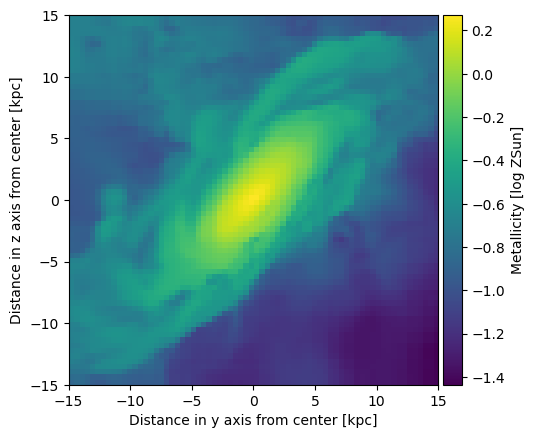

In [4]:
%matplotlib inline

fig, ax = plt.subplots() 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(np.log10(np.array(frb_x["gas","metallicity"])), 
                        cmap='viridis', extent = [-size/2, size/2, -size/2, size/2])
fig.colorbar(im, cax=cax, orientation='vertical')
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('Metallicity [log ZSun]')

#ax.set_title("Metallicity plot of Tempest RD0042") => Plotting title / optional 
ax.set_xlabel('Distance in y axis from center [kpc]')
ax.set_ylabel('Distance in z axis from center [kpc]')

plt.show()

#plt.savefig(foggie_output + 'FRB_90.png')   => Figure saving directory + file name 

In [5]:
# size/xres or yres => 428pc/pixel(=index) for 30kpc/70pixel(=index)

In [6]:
#Creating nparray from fixed resolution buffer 

od_x = np.array(frb_x["gas","metallicity"])
od_y = np.array(frb_y["gas","metallicity"])
od_z = np.array(frb_z["gas","metallicity"])

In [7]:
#Defining function that converts each pixel into radius from galactic center by indexing /func1 

def func1(od):
    OD_Met=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_metal_value = od[i][j]
            xindex = i
            yindex = j
            Radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/xres)
            OD_Met.append(this_metal_value)
            OD_Rad.append(Radius)
            
    return OD_Rad, OD_Met

OD_Rad, OD_Met_X = func1(od_x)
OD_Rad, OD_Met_Y = func1(od_y)
OD_Rad, OD_Met_Z = func1(od_z)

In [8]:
# Setting basic parameters 

#max_radius = size/2 #Actual maximum radius [kpc]
max_radius = 14 #Actual maximum radius - 14 until we figure out 14-15 problem
min_radius = 0      #Actual minimum radius [kpc]
increment = 1     #Radius increment per bin [kpc]

#Creating bins for x axial metallicity plot by defining function / func2

def func2(OD_Rad, OD_Met):
    index = 0 
    metallicitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_metallicity = np.array(OD_Met)[sort]
    radiuslist = np.arange(min_radius, max_radius, increment) + increment/2
    while index < len(radiuslist):
        left_edge = index*increment
        right_edge = left_edge + increment 
        new_metallicity = np.array(sorted_metallicity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        metallicitylist.append((np.mean(new_metallicity)))
        index +=1
    return radiuslist, metallicitylist

In [9]:
#Binned radius/metallicity for 3 axes

OD_Radius, OD_Met_Xaxis = func2(OD_Rad, OD_Met_X)
OD_Radius, OD_Met_Yaxis = func2(OD_Rad, OD_Met_Y)
OD_Radius, OD_Met_Zaxis = func2(OD_Rad, OD_Met_Z)

(-1.3, 0.4)

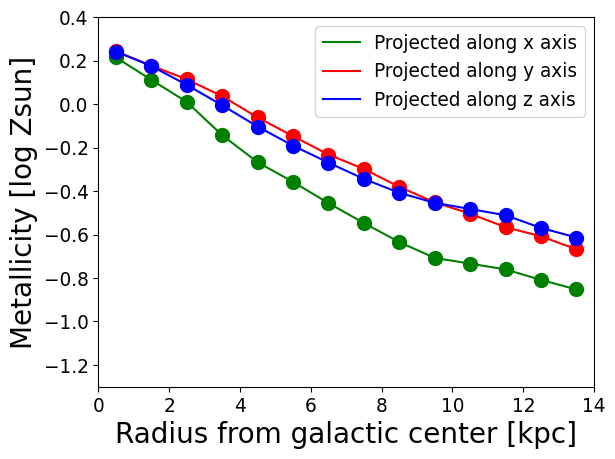

In [10]:
#Plotting metallicity gradient in x,y,z axis with proper labeling and legend

markersize = 10
fontsize = 20

plt.plot(OD_Radius, np.log10(OD_Met_Xaxis), 'g-', label = 'Projected along x axis')
plt.plot(OD_Radius, np.log10(OD_Met_Xaxis),'go', markersize=markersize)
plt.plot(OD_Radius, np.log10(OD_Met_Yaxis), 'r-',label = 'Projected along y axis')
plt.plot(OD_Radius, np.log10(OD_Met_Yaxis),'ro',markersize=markersize)
plt.plot(OD_Radius, np.log10(OD_Met_Zaxis), 'b-',label = 'Projected along z axis')
plt.plot(OD_Radius, np.log10(OD_Met_Zaxis),'bo', markersize=markersize)
plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
plt.ylabel("Metallicity [log Zsun]", fontsize = fontsize)
plt.legend(loc="upper right", fontsize = fontsize/1.5)
plt.xticks(fontsize = fontsize/1.5)
plt.yticks(fontsize = fontsize/1.5)
plt.xlim([min_radius, max_radius])
plt.ylim(-1.3, 0.4) #Set the ylim to be -1.3-0.4
#plt.show() - optional 

(0.0, 14.0)

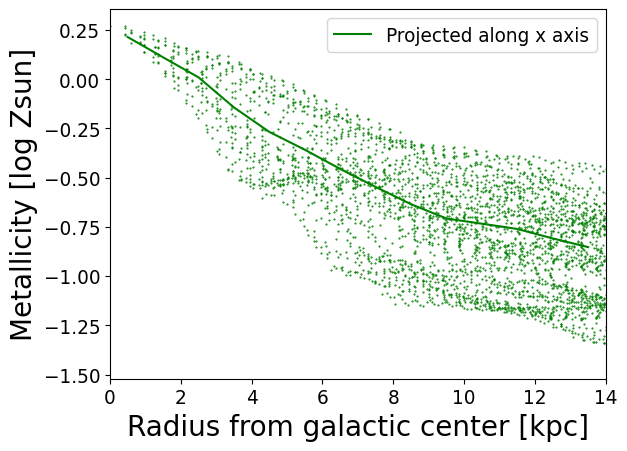

In [11]:
plt.plot(OD_Radius, np.log10(OD_Met_Xaxis), 'g-', label = 'Projected along x axis')
#plt.plot(OD_Radius, np.log10(OD_Met_Xaxis),'go', markersize=markersize)
#plt.plot(OD_Radius, np.log10(OD_Met_Yaxis), 'r-',label = 'Projected along y axis')
#plt.plot(OD_Radius, np.log10(OD_Met_Yaxis),'ro',markersize=markersize)
#plt.plot(OD_Radius, np.log10(OD_Met_Zaxis), 'b-',label = 'Projected along z axis')
#plt.plot(OD_Radius, np.log10(OD_Met_Zaxis),'bo', markersize=markersize)
plt.plot(OD_Rad, np.log10(OD_Met_X), 'go', markersize = 0.5)
#plt.plot(OD_Radius, np.log10(OD_Met_Y), 'ro', markersize = 0.5)
#plt.plot(OD_Radius, np.log10(OD_Met_Z), 'bo', markersize = 0.5)
plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
plt.ylabel("Metallicity [log Zsun]", fontsize = fontsize)
plt.legend(loc="upper right", fontsize = fontsize/1.5)
plt.xticks(fontsize = fontsize/1.5)
plt.yticks(fontsize = fontsize/1.5)
plt.xlim([min_radius, max_radius])